In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow

os.listdir()

['sample_submission.csv',
 'EDA and LSTM tf.ipynb',
 'test.zip',
 'train',
 'depths.csv',
 'pytorch1.ipynb',
 'train.zip',
 '.ipynb_checkpoints',
 'unet_resnet_v0.model',
 'resnet_unet_v0.ipynb',
 'train.csv',
 'test',
 'EDA and LSTM.ipynb',
 'registryupload_1.csv',
 'unet_resnet_v0.csv',
 'registryupload_2.csv']

In [52]:
df1 = pd.read_csv('registryupload_1.csv')
df2 = pd.read_csv('registryupload_2.csv')

df = df1.append(df2).reset_index()

def extract_date(startdate):
    parts = startdate.split()
    return parts[0]



df["Date"] = pd.to_datetime(df.JobStartDate, format='%m/%d/%Y %H:%M:%S AM', errors = 'coerce', utc=False)
hard_date = datetime.date(1980,1,1)
df["days_from"] = df.Date - hard_date
df.days_from = df.days_from.dt.days

print("Full data shape:", df.shape)
print(df.dtypes)
df.head(5)

Full data shape: (143590, 24)
index                               int64
pKey                               object
JobStartDate                       object
JobEndDate                         object
APINumber                           int64
StateNumber                         int64
CountyNumber                        int64
OperatorName                       object
WellName                           object
Latitude                          float64
Longitude                         float64
Projection                         object
TVD                               float64
TotalBaseWaterVolume              float64
TotalBaseNonWaterVolume           float64
StateName                          object
CountyName                         object
FFVersion                           int64
FederalWell                          bool
IndianWell                           bool
Source                            float64
DTMOD                             float64
Date                       datetime64[ns]
days

,index,pKey,JobStartDate,JobEndDate,APINumber,StateNumber,CountyNumber,OperatorName,WellName,Latitude,...,TotalBaseNonWaterVolume,StateName,CountyName,FFVersion,FederalWell,IndianWell,Source,DTMOD,Date,days_from
0,0,f66add2e-8ea8-4843-9388-24725b5d37c1,5/19/1982 12:00:00 AM,5/19/1982 12:00:00 AM,49009219470000,49,9,"Chesapeake Operating, Inc.",WILLIAM VALENTINE 1,42.972810,...,NaN,WYOMING,CONVERSE,1,False,False,NaN,NaN,1982-05-19 12:00:00,869.0
1,1,95f0904c-2556-4912-9f5a-34913ba57625,2/7/1995 12:00:00 AM,2/7/1995 12:00:00 AM,49009228850000,49,9,"Chesapeake Operating, Inc.",LIZARD HEAD 1-8H RE,42.851470,...,NaN,WYOMING,CONVERSE,1,False,False,NaN,NaN,1995-02-07 12:00:00,5516.0
2,2,5a9513e7-b79f-4488-9f64-fa0960e595f3,6/11/1996 12:00:00 AM,6/11/1996 12:00:00 AM,42335355480000,42,335,Energen Resources Corporation,North Westbrook Unit/Well No. 3032,32.440260,...,NaN,Texas,Mitchell,1,False,False,NaN,NaN,1996-06-11 12:00:00,6006.0
3,3,36368c95-a097-40ea-bb9f-2b647de7b913,12/13/2001 12:00:00 AM,12/13/2001 12:00:00 AM,42395313840000,42,395,XTO Energy/ExxonMobil,Olene Reagan 3-1,31.257980,...,NaN,Texas,Robertson,1,False,False,NaN,NaN,2001-12-13 12:00:00,8017.0
4,4,d7fa1dbc-b688-4b2b-8a3c-29ff3887bbbe,9/22/2008 12:00:00 AM,9/22/2008 12:00:00 AM,37059247370000,37,59,CONSOL Energy Inc.,CNX3,39.893301,...,NaN,PA,Greene,1,False,False,NaN,NaN,2008-09-22 12:00:00,10492.0


In [53]:
# Remove rows where no water volume exists
df = df[df['TotalBaseWaterVolume'].notnull()]
df['Latitude'].replace(376223, np.nan, inplace=True)
df = df[df['Latitude'].notnull()]
df = df[df['Longitude'].notnull()]
df = df[df['TVD'].notnull()]
print("Data shape:", df.shape)
df.head()


Data shape: (113420, 24)


,index,pKey,JobStartDate,JobEndDate,APINumber,StateNumber,CountyNumber,OperatorName,WellName,Latitude,...,TotalBaseNonWaterVolume,StateName,CountyName,FFVersion,FederalWell,IndianWell,Source,DTMOD,Date,days_from
5,5,05e11984-99f4-4727-aebd-15f20e621316,11/19/2008 12:00:00 AM,11/19/2008 12:00:00 AM,37105214840000,37,105,Pennsylvania General Energy,Fisk Hollow PV PAD A #2146,41.847809,...,NaN,Pennsylvania,Potter,1,False,False,NaN,NaN,2008-11-19 12:00:00,10550.0
14,14,7ecb3f11-f69c-4957-9ee9-7ac5c9eadd05,6/29/2009 12:00:00 AM,6/29/2009 12:00:00 AM,37105215000000,37,105,Pennsylvania General Energy,Reed Run Keating PAD A #2145,41.728259,...,NaN,Pennsylvania,Potter,1,False,False,NaN,NaN,2009-06-29 12:00:00,10772.0
15,15,41fa065f-1d8d-4e86-a21d-ce6d5fe89e77,7/7/2009 12:00:00 AM,7/7/2009 12:00:00 AM,37105212980000,37,105,Pennsylvania General Energy,Pine Hill #1941A,41.614847,...,NaN,Pennsylvania,Potter,1,False,False,NaN,NaN,2009-07-07 12:00:00,10780.0
16,16,f98e67c5-8b7b-45b9-84d4-b4e5f2de6e86,7/13/2009 12:00:00 AM,7/13/2009 12:00:00 AM,37059251250000,37,59,Energy Corporation of America,Henderson King #2MH,39.883933,...,NaN,PA,Greene,1,False,False,NaN,NaN,2009-07-13 12:00:00,10786.0
18,18,6246ef12-8aca-47dc-9271-b93a21b9cd1c,8/3/2009 12:00:00 AM,8/3/2009 12:00:00 AM,37053290190000,37,53,Pennsylvania General Energy,Forest #2124,41.550398,...,NaN,Pennsylvania,Forest,1,False,False,NaN,NaN,2009-08-03 12:00:00,10807.0


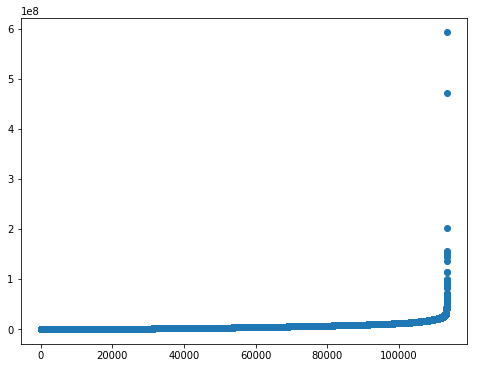

In [54]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.TotalBaseWaterVolume.values))


In [71]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_prev = 10
n_features = 5
n_obs = n_prev * n_features

# First let's get the full df of important features and output
columns = ['TotalBaseWaterVolume','Latitude', 'Longitude', 'TVD', 'days_from']
df_raw = df[columns]
df_raw = df_raw[df_raw.days_from.notnull()]

# Normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df_raw)

reframed = series_to_supervised(scaled, n_prev, 1)
# Drop extra columns
reframed = reframed[:, :-4]


print('Reframed for LSTM dataset shape:', reframed.shape)
print(reframed.head())

TypeError: unhashable type: 'slice'

In [43]:
# Split data into train and test sets
# We will try using a 99%/1% split
values = reframed.values
train_size = int(0.99 * reframed.shape[0])

train = values[:train_size, :]
test = values[train_size:, :]

# Split into inputs and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1,], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(104079, 1, 5) (104079,) (1052, 1, 5) (1052,)


Train on 104079 samples, validate on 1052 samples
Epoch 1/30
 - 4s - loss: 0.0366 - val_loss: 0.0212
Epoch 2/30
 - 3s - loss: 0.0176 - val_loss: 0.0202
Epoch 3/30
 - 3s - loss: 0.0162 - val_loss: 0.0195
Epoch 4/30
 - 3s - loss: 0.0154 - val_loss: 0.0195
Epoch 5/30
 - 3s - loss: 0.0152 - val_loss: 0.0195
Epoch 6/30
 - 3s - loss: 0.0152 - val_loss: 0.0194
Epoch 7/30
 - 3s - loss: 0.0152 - val_loss: 0.0196
Epoch 8/30
 - 3s - loss: 0.0152 - val_loss: 0.0194
Epoch 9/30
 - 3s - loss: 0.0152 - val_loss: 0.0196
Epoch 10/30
 - 3s - loss: 0.0151 - val_loss: 0.0198
Epoch 11/30
 - 3s - loss: 0.0151 - val_loss: 0.0196
Epoch 12/30
 - 3s - loss: 0.0151 - val_loss: 0.0196
Epoch 13/30
 - 4s - loss: 0.0151 - val_loss: 0.0194
Epoch 14/30
 - 4s - loss: 0.0151 - val_loss: 0.0195
Epoch 15/30
 - 3s - loss: 0.0151 - val_loss: 0.0195
Epoch 16/30
 - 3s - loss: 0.0151 - val_loss: 0.0198
Epoch 17/30
 - 3s - loss: 0.0151 - val_loss: 0.0195
Epoch 18/30
 - 3s - loss: 0.0151 - val_loss: 0.0196
Epoch 19/30
 - 3s - los

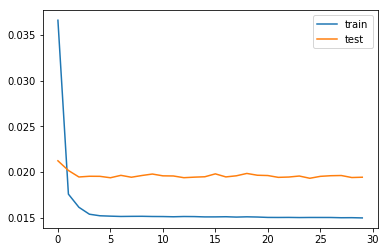

In [66]:
# Design model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size = 72, validation_data = (test_X, test_y), verbose=2, shuffle=False)

# plot
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [68]:
import math
from sklearn.metrics import mean_squared_error

# Predict on test data
yhat = model.predict(test_X)
test_X_rev = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_rev[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat)
# invert scaling for actual
test_y_rev = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_rev, test_X_rev[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y)
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


[3.97362303e+08 4.08251587e+08 3.87222864e+08 ... 4.04737358e+08
 3.94615154e+08 4.07322615e+08]
[4.09761281e+08 3.85863823e+08 3.85864019e+08 ... 3.94143542e+08
 4.08703686e+08 4.20535665e+08]
Test RMSE: 17525985.676
